In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as img
import math
import pymap3d as pm
import numpy as np
import pandas as pd


In [65]:
from numpy import array, cross
from numpy.linalg import solve, norm

# # define lines A and B by two points
# XA0 = array([1, 0, 0])
# XA1 = array([1, 1, 1])
# XB0 = array([0, 0, 0])
# XB1 = array([0, 0, 1])

def estimate_point_pos(XA0, XA1, XB0, XB1):
    XA0 = array(XA0)
    XA1 = array(XA1)
    XB0 = array(XB0)
    XB1 = array(XB1)
    # 
    # compute unit vectors of directions of lines A and B
    UA = (XA1 - XA0) / norm(XA1 - XA0)
    UB = (XB1 - XB0) / norm(XB1 - XB0)
    # find unit direction vector for line C, which is perpendicular to lines A and B
    UC = cross(UB, UA); UC /= norm(UC)

    # solve the system derived in user2255770's answer from StackExchange: https://math.stackexchange.com/q/1993990
    RHS = XB0 - XA0
    LHS = array([UA, -UB, UC]).T
    sol = solve(LHS, RHS)
    #print("Middle", sol)
    return(sol)
    # prints "[ 0. -0.  1.]"


def closestDistanceBetweenLines(a0,a1,b0,b1,clampAll=False,clampA0=False,clampA1=False,clampB0=False,clampB1=False):
# https://stackoverflow.com/questions/2824478/shortest-distance-between-two-line-segments
    ''' Given two lines defined by numpy.array pairs (a0,a1,b0,b1)
        Return the closest points on each segment and their distance
    '''
    
    
    a0 = np.array(a0)
    a1 = np.array(a1)
    b0 = np.array(b0)
    b1 = np.array(b1)

    # If clampAll=True, set all clamps to True
    if clampAll:
        clampA0=True
        clampA1=True
        clampB0=True
        clampB1=True


    # Calculate denomitator
    A = a1 - a0
    B = b1 - b0
    magA = np.linalg.norm(A)
    magB = np.linalg.norm(B)
    
    _A = A / magA
    _B = B / magB
    
    cross = np.cross(_A, _B);
    denom = np.linalg.norm(cross)**2
    
    
    # If lines are parallel (denom=0) test if lines overlap.
    # If they don't overlap then there is a closest point solution.
    # If they do overlap, there are infinite closest positions, but there is a closest distance
    if not denom:
        d0 = np.dot(_A,(b0-a0))
        
        # Overlap only possible with clamping
        if clampA0 or clampA1 or clampB0 or clampB1:
            d1 = np.dot(_A,(b1-a0))
            
            # Is segment B before A?
            if d0 <= 0 >= d1:
                if clampA0 and clampB1:
                    if np.absolute(d0) < np.absolute(d1):
                        return a0,b0,np.linalg.norm(a0-b0)
                    return a0,b1,np.linalg.norm(a0-b1)
                
                
            # Is segment B after A?
            elif d0 >= magA <= d1:
                if clampA1 and clampB0:
                    if np.absolute(d0) < np.absolute(d1):
                        return a1,b0,np.linalg.norm(a1-b0)
                    return a1,b1,np.linalg.norm(a1-b1)
                
                
        # Segments overlap, return distance between parallel segments
        return None, None,None,np.linalg.norm(((d0*_A)+a0)-b0)
        
    
    
    # Lines criss-cross: Calculate the projected closest points
    t = (b0 - a0);
    detA = np.linalg.det([t, _B, cross])
    detB = np.linalg.det([t, _A, cross])

    t0 = detA/denom;
    t1 = detB/denom;

    pA = a0 + (_A * t0) # Projected closest point on segment A
    pB = b0 + (_B * t1) # Projected closest point on segment B


    # Clamp projections
    if clampA0 or clampA1 or clampB0 or clampB1:
        if clampA0 and t0 < 0:
            pA = a0
        elif clampA1 and t0 > magA:
            pA = a1
        
        if clampB0 and t1 < 0:
            pB = b0
        elif clampB1 and t1 > magB:
            pB = b1
            
        # Clamp projection A
        if (clampA0 and t0 < 0) or (clampA1 and t0 > magA):
            dot = np.dot(_B,(pA-b0))
            if clampB0 and dot < 0:
                dot = 0
            elif clampB1 and dot > magB:
                dot = magB
            pB = b0 + (_B * dot)
    
        # Clamp projection B
        if (clampB0 and t1 < 0) or (clampB1 and t1 > magB):
            dot = np.dot(_A,(pB-a0))
            if clampA0 and dot < 0:
                dot = 0
            elif clampA1 and dot > magA:
                dot = magA
            pA = a0 + (_A * dot)

    
    return (pA+pB)/2, pA, pB, np.linalg.norm(pA-pB)


from operator import add
from mpl_toolkits.mplot3d import Axes3D

def spherical_to_cartesian(theta, phi): # 90-alt, az
    theta = math.radians(theta)
    phi = math.radians(phi)
    x = math.cos(phi) * math.sin(theta)
    y = math.sin(phi) * math.sin(theta)
    z = math.cos(theta)
    return x*50000, y*50000, z*50000

In [66]:
%matplotlib inline


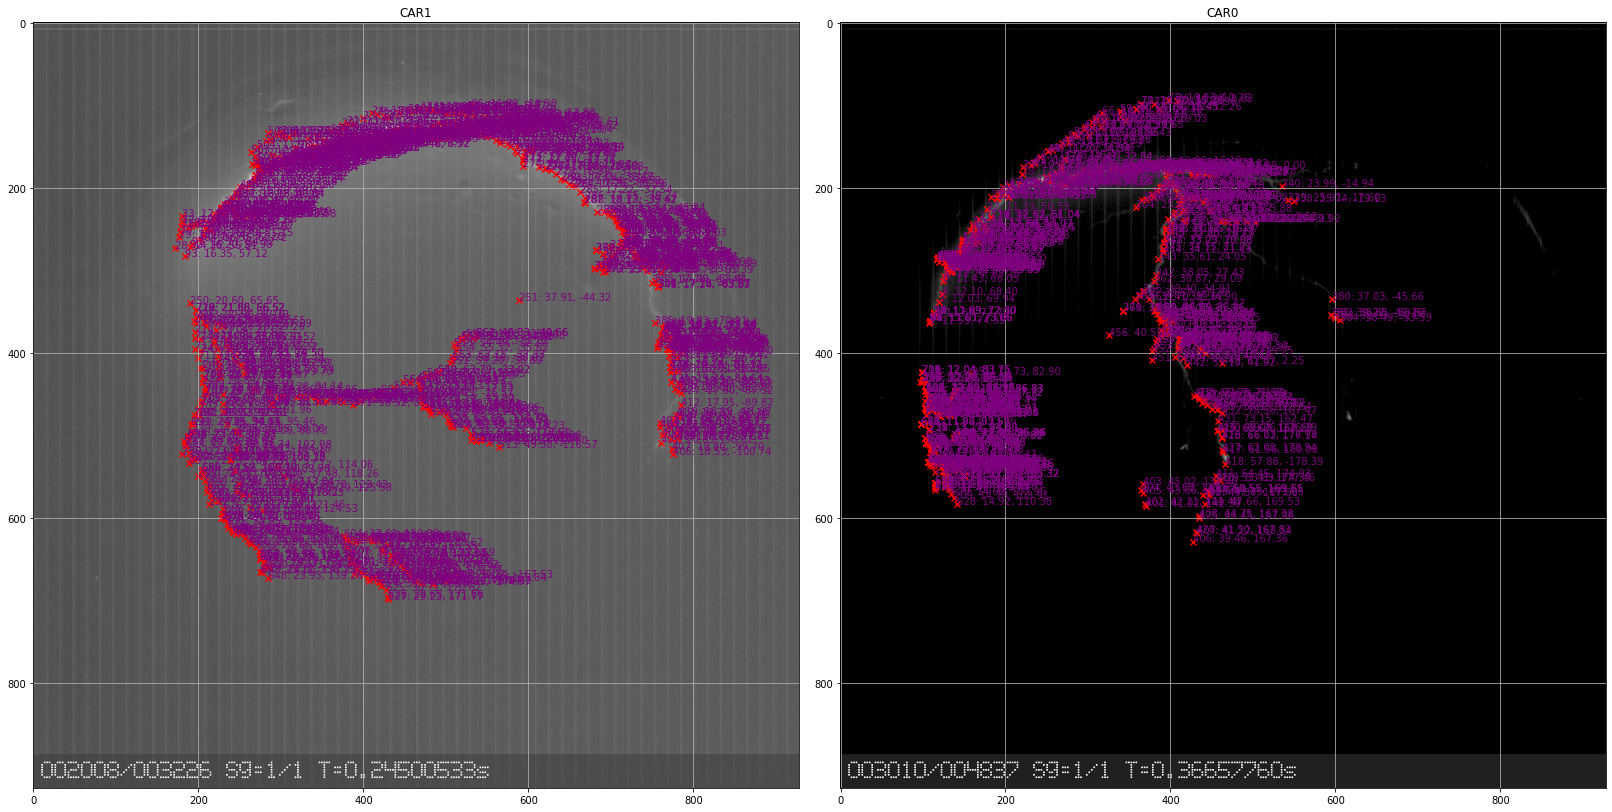

In [68]:
def chronos_lens(x, y):
    
    w = 928
    h = 928
    
    cx = w/2
    cy = h/2
    
    alt = math.degrees(math.asin(1-math.sqrt( (x-cx)**2 + (y-cy)**2 )/(928/2)))
    az = math.degrees(math.atan2(cx-x, cy-y))
    return (alt, az)


class Camera():
    def __init__(self, file, coord, attitude = (0, 0, 0), name = "Kamera", lens_calculator = chronos_lens, offset = 0):
    # attitude: pitch, roll, yaw
        self.file = file
        self.name = name
        self.coord = coord
        self.attitude = attitude
        self.lens_calculator = lens_calculator
        self.offset = offset


#cam1 = Camera("./b1_a.tiff", (13.7387362, 50.1695947, 370), (0, 0, 0), name = "CAR1")
#cam0 = Camera("./b1_b.jpg", (13.4116515, 50.1306232, 400), (0, 0, 0), name = "CAR0")

cam1 = Camera("./b1_a.tiff", (13.4116515, 50.1306232, 400), (0, 0, 0), name = "CAR1")
cam0 = Camera("./b1_b.jpg", (13.7387362, 50.1695947, 370), (0, 0, 0), name = "CAR0")
cameras = [cam1, cam0]


class Scena():
    def __init__(self, center = (14.5, 50, 300), cameras = []):
        self.area_center = center
        self.cameras = []

lat0 = 13.5
lon0 = 50.15
alt0 = 300
ref_coord = (lat0, lon0, alt0)

import matplotlib.pyplot as plt
scale = 1.5
plt.rcParams["figure.figsize"] = (15*scale,15/2*scale)

f, ax = plt.subplots(1,2)
ax[0].imshow(img.imread(cam0.file), cmap="gray")
ax[0].grid(which='both')
ax[0].set_title(cameras[0].name)
ax[1].imshow(img.imread(cam1.file), cmap="gray")
ax[1].grid(which='both')
ax[1].set_title(cameras[1].name)


#data = [[(268, 185), (124, 313)], [(215, 251), (107, 364)], [(221, 234), (112, 355)], [(231, 220), (119, 338)], [(248, 203), (123, 329)], [(275, 176), (125, 307)], [(288, 169), (129, 295)], [(289, 160), (134, 288)], [(296, 163), (134, 295)], [(308, 166), (134, 295)], [(317, 152), (139, 279)], [(321, 159), (145, 278)], [(333, 153), (146, 273)], [(346, 149), (147, 268)], [(333, 141), (148, 263)], [(352, 142), (149, 262)], [(344, 139), (147, 265)], [(361, 131), (157, 251)], [(370, 134), (163, 253)], [(376, 129), (160, 246)], [(374, 124), (161, 244)], [(380, 122), (168, 238)], [(388, 123), (177, 226)], [(399, 116), (183, 211)], [(410, 109), (192, 209)], [(417, 111), (193, 206)], [(428, 114), (197, 199)], [(425, 113), (204, 197)], [(172, 273), (113, 352)], [(177, 260), (113, 352)], [(178, 254), (113, 352)], [(179, 247), (113, 352)], [(180, 242), (113, 352)], [(180, 234), (113, 352)], [(187, 248), (113, 352)], [(191, 246), (113, 352)], [(196, 245), (113, 352)], [(200, 243), (113, 352)], [(443, 110), (220, 183)], [(454, 107), (221, 175)], [(461, 107), (231, 173)], [(468, 105), (235, 169)], [(477, 105), (235, 170)], [(484, 106), (242, 163)], [(492, 106), (252, 156)], [(491, 122), (252, 156)], [(499, 109), (256, 154)], [(503, 109), (266, 150)], [(514, 108), (269, 146)], [(514, 108), (277, 145)], [(525, 112), (276, 140)], [(526, 115), (283, 135)], [(534, 113), (287, 136)], [(546, 114), (287, 136)], [(553, 120), (301, 136)], [(565, 117), (305, 126)], [(569, 122), (316, 126)], [(575, 121), (320, 119)], [(574, 125), (340, 113)], [(577, 112), (339, 107)], [(586, 132), (345, 119)], [(511, 110), (295, 129)], [(518, 108), (296, 127)], [(526, 104), (305, 120)], [(526, 104), (308, 118)], [(529, 105), (310, 116)], [(530, 101), (317, 110)], [(581, 118), (358, 105)], [(583, 123), (358, 105)], [(589, 129), (358, 105)], [(598, 133), (364, 98)], [(573, 117), (364, 98)], [(578, 115), (364, 98)], [(577, 118), (380, 99)], [(583, 119), (386, 105)], [(604, 128), (397, 94)], [(606, 123), (408, 95)], [(267, 234), (108, 361)], [(261, 232), (108, 361)], [(258, 233), (108, 361)], [(255, 235), (108, 361)], [(247, 234), (108, 361)], [(244, 232), (108, 361)], [(244, 226), (108, 361)], [(241, 225), (108, 361)], [(231, 228), (108, 361)], [(230, 232), (108, 361)], [(220, 240), (108, 361)], [(216, 242), (108, 361)], [(211, 250), (108, 361)], [(203, 262), (108, 361)], [(192, 268), (108, 361)], [(190, 272), (108, 361)], [(184, 283), (108, 361)], [(279, 178), (145, 280)], [(291, 173), (149, 276)], [(294, 171), (149, 276)], [(302, 167), (149, 276)], [(314, 167), (149, 276)], [(305, 169), (162, 262)], [(310, 167), (162, 262)], [(317, 163), (162, 262)], [(322, 158), (162, 262)], [(335, 149), (164, 257)], [(340, 149), (164, 257)], [(353, 150), (164, 257)], [(365, 146), (164, 257)], [(375, 145), (164, 257)], [(372, 148), (174, 246)], [(372, 148), (174, 246)], [(381, 144), (174, 246)], [(389, 138), (174, 246)], [(404, 136), (174, 246)], [(415, 140), (182, 236)], [(402, 137), (182, 236)], [(409, 137), (182, 236)], [(424, 143), (182, 236)], [(430, 144), (182, 236)], [(431, 139), (182, 236)], [(430, 135), (182, 236)], [(432, 131), (182, 236)], [(380, 143), (190, 213)], [(393, 139), (190, 213)], [(358, 146), (190, 213)], [(375, 146), (190, 213)], [(393, 143), (190, 213)], [(401, 137), (190, 213)], [(413, 135), (203, 211)], [(420, 140), (203, 211)], [(432, 138), (201, 207)], [(441, 129), (201, 207)], [(453, 127), (201, 207)], [(464, 127), (201, 207)], [(466, 128), (201, 207)], [(478, 130), (201, 207)], [(483, 127), (201, 207)], [(485, 127), (201, 207)], [(496, 125), (201, 207)], [(506, 125), (201, 207)], [(514, 124), (201, 207)], [(441, 135), (201, 207)], [(446, 135), (201, 207)], [(455, 135), (201, 207)], [(464, 135), (201, 207)], [(473, 137), (201, 207)], [(477, 139), (201, 207)], [(485, 141), (201, 207)], [(492, 140), (201, 207)], [(495, 137), (201, 207)], [(504, 138), (201, 207)], [(502, 122), (201, 207)], [(508, 120), (205, 201)], [(516, 119), (205, 201)], [(523, 124), (205, 201)], [(533, 122), (205, 201)], [(510, 129), (205, 201)], [(514, 129), (205, 201)], [(523, 130), (205, 201)], [(530, 130), (205, 201)], [(532, 122), (216, 196)], [(532, 122), (216, 196)], [(538, 126), (216, 196)], [(542, 127), (216, 196)], [(532, 132), (216, 196)], [(535, 135), (216, 196)], [(544, 136), (216, 196)], [(548, 137), (238, 193)], [(578, 150), (255, 186)], [(586, 150), (255, 186)], [(600, 155), (261, 182)], [(598, 156), (263, 184)], [(600, 155), (267, 181)], [(604, 154), (267, 174)], [(604, 153), (267, 175)], [(596, 157), (271, 165)], [(596, 157), (271, 165)], [(270, 185), (135, 300)], [(277, 176), (135, 300)], [(286, 175), (135, 300)], [(289, 173), (135, 300)], [(291, 171), (135, 300)], [(296, 172), (135, 300)], [(301, 170), (135, 300)], [(307, 165), (135, 300)], [(311, 164), (135, 300)], [(315, 164), (135, 300)], [(316, 162), (135, 300)], [(317, 162), (135, 300)], [(323, 160), (135, 300)], [(328, 160), (135, 300)], [(337, 163), (135, 300)], [(333, 163), (135, 300)], [(333, 161), (135, 300)], [(331, 159), (135, 300)], [(340, 160), (135, 300)], [(343, 158), (135, 300)], [(345, 158), (135, 300)], [(346, 158), (135, 300)], [(347, 156), (135, 300)], [(351, 154), (135, 300)], [(354, 154), (135, 300)], [(357, 155), (135, 300)], [(361, 154), (135, 300)], [(361, 153), (135, 300)], [(362, 149), (135, 300)], [(364, 147), (135, 300)], [(365, 147), (135, 300)], [(368, 143), (135, 300)], [(372, 144), (135, 300)], [(483, 680), (137, 576)], [(471, 679), (131, 559)], [(450, 662), (130, 549)], [(433, 655), (122, 539)], [(430, 633), (123, 532)], [(412, 628), (127, 543)], [(410, 627), (126, 537)], [(390, 630), (125, 533)], [(392, 627), (125, 533)], [(296, 539), (117, 512)], [(304, 550), (117, 512)], [(314, 563), (117, 512)], [(320, 567), (117, 512)], [(281, 658), (115, 563)], [(276, 648), (115, 563)], [(273, 640), (114, 545)], [(260, 628), (111, 537)], [(245, 620), (109, 526)], [(229, 600), (112, 515)], [(227, 600), (109, 511)], [(232, 596), (108, 512)], [(229, 595), (107, 508)], [(213, 584), (107, 493)], [(213, 561), (106, 485)], [(200, 550), (104, 469)], [(195, 529), (106, 470)], [(198, 528), (104, 470)], [(180, 523), (104, 470)], [(184, 511), (104, 470)], [(187, 504), (104, 470)], [(192, 495), (104, 470)], [(193, 487), (104, 470)], [(201, 476), (104, 470)], [(202, 461), (104, 470)], [(209, 442), (104, 470)], [(204, 437), (100, 433)], [(206, 431), (100, 433)], [(205, 418), (100, 433)], [(203, 398), (100, 433)], [(202, 383), (100, 433)], [(195, 362), (100, 433)], [(190, 340), (100, 433)], [(589, 336), (159, 426)], [(709, 244), (393, 173)], [(698, 233), (399, 182)], [(702, 234), (411, 180)], [(706, 236), (419, 174)], [(709, 238), (431, 182)], [(710, 243), (426, 185)], [(718, 249), (453, 182)], [(713, 246), (443, 184)], [(540, 126), (249, 187)], [(541, 129), (252, 190)], [(543, 131), (253, 191)], [(548, 132), (254, 193)], [(554, 137), (261, 198)], [(561, 142), (267, 196)], [(565, 142), (268, 196)], [(574, 147), (272, 195)], [(566, 146), (271, 195)], [(584, 155), (282, 187)], [(586, 158), (289, 185)], [(595, 162), (296, 181)], [(594, 168), (295, 179)], [(594, 165), (304, 181)], [(594, 174), (315, 177)], [(613, 175), (330, 175)], [(620, 177), (333, 179)], [(621, 176), (337, 179)], [(627, 178), (340, 180)], [(634, 183), (344, 178)], [(639, 189), (350, 176)], [(643, 191), (356, 174)], [(649, 195), (358, 176)], [(653, 198), (357, 177)], [(657, 198), (362, 178)], [(663, 205), (376, 175)], [(669, 213), (376, 176)], [(667, 217), (379, 170)], [(668, 218), (384, 174)], [(683, 230), (395, 173)], [(696, 230), (399, 178)], [(692, 229), (402, 178)], [(703, 227), (420, 176)], [(706, 240), (426, 181)], [(706, 238), (432, 186)], [(709, 247), (436, 182)], [(711, 245), (444, 182)], [(712, 248), (443, 184)], [(717, 248), (450, 185)], [(728, 258), (464, 176)], [(714, 254), (388, 175)], [(716, 252), (395, 182)], [(718, 262), (395, 188)], [(717, 267), (399, 196)], [(717, 269), (358, 223)], [(715, 267), (379, 211)], [(715, 267), (391, 198)], [(715, 267), (384, 203)], [(715, 267), (370, 214)], [(715, 267), (365, 215)], [(715, 267), (378, 208)], [(715, 267), (387, 200)], [(715, 267), (389, 199)], [(699, 272), (389, 199)], [(717, 271), (396, 194)], [(726, 273), (404, 196)], [(728, 281), (407, 200)], [(730, 280), (409, 208)], [(735, 284), (422, 212)], [(734, 283), (429, 212)], [(741, 286), (443, 215)], [(736, 282), (432, 213)], [(729, 285), (412, 220)], [(731, 288), (417, 227)], [(734, 290), (417, 227)], [(734, 290), (414, 230)], [(739, 297), (418, 239)], [(744, 301), (417, 241)], [(746, 294), (448, 228)], [(742, 288), (440, 217)], [(735, 285), (427, 213)], [(735, 285), (427, 213)], [(750, 315), (461, 240)], [(753, 313), (474, 238)], [(757, 319), (465, 240)], [(757, 319), (470, 241)], [(757, 319), (479, 240)], [(757, 319), (492, 240)], [(761, 302), (550, 216)], [(765, 295), (543, 215)], [(760, 293), (535, 198)], [(757, 320), (503, 241)], [(705, 280), (382, 306)], [(709, 275), (385, 287)], [(711, 271), (391, 278)], [(711, 271), (391, 274)], [(711, 271), (392, 267)], [(714, 271), (392, 266)], [(714, 271), (394, 258)], [(714, 271), (394, 251)], [(713, 265), (394, 251)], [(717, 254), (394, 251)], [(717, 254), (395, 260)], [(717, 254), (395, 249)], [(717, 254), (397, 238)], [(717, 255), (400, 253)], [(717, 255), (401, 244)], [(717, 255), (403, 232)], [(717, 255), (405, 229)], [(717, 255), (410, 220)], [(717, 255), (414, 214)], [(717, 255), (414, 211)], [(701, 284), (380, 313)], [(695, 288), (374, 335)], [(690, 280), (357, 335)], [(690, 280), (362, 330)], [(690, 280), (367, 325)], [(694, 290), (384, 343)], [(687, 292), (380, 350)], [(682, 276), (342, 349)], [(682, 276), (342, 349)], [(682, 276), (342, 349)], [(693, 301), (395, 354)], [(693, 301), (388, 359)], [(689, 294), (388, 359)], [(695, 297), (396, 355)], [(691, 302), (402, 361)], [(681, 297), (388, 363)], [(680, 298), (395, 376)], [(685, 297), (393, 377)], [(765, 367), (596, 335)], [(771, 379), (594, 354)], [(770, 382), (598, 355)], [(780, 391), (600, 358)], [(776, 388), (605, 360)]]
data = [[(268, 185), (124, 313)], [(215, 251), (107, 364)], [(221, 234), (112, 355)], [(231, 220), (119, 338)], [(248, 203), (123, 329)], [(275, 176), (125, 307)], [(288, 169), (129, 295)], [(289, 160), (134, 288)], [(296, 163), (134, 295)], [(308, 166), (134, 295)], [(317, 152), (139, 279)], [(321, 159), (145, 278)], [(333, 153), (146, 273)], [(346, 149), (147, 268)], [(333, 141), (148, 263)], [(352, 142), (149, 262)], [(344, 139), (147, 265)], [(361, 131), (157, 251)], [(370, 134), (163, 253)], [(376, 129), (160, 246)], [(374, 124), (161, 244)], [(380, 122), (168, 238)], [(388, 123), (177, 226)], [(399, 116), (183, 211)], [(410, 109), (192, 209)], [(417, 111), (193, 206)], [(428, 114), (197, 199)], [(425, 113), (204, 197)], [(172, 273), (113, 352)], [(177, 260), (113, 352)], [(178, 254), (113, 352)], [(179, 247), (113, 352)], [(180, 242), (113, 352)], [(180, 234), (113, 352)], [(187, 248), (113, 352)], [(191, 246), (113, 352)], [(196, 245), (113, 352)], [(200, 243), (113, 352)], [(443, 110), (220, 183)], [(454, 107), (221, 175)], [(461, 107), (231, 173)], [(468, 105), (235, 169)], [(477, 105), (235, 170)], [(484, 106), (242, 163)], [(492, 106), (252, 156)], [(491, 122), (252, 156)], [(499, 109), (256, 154)], [(503, 109), (266, 150)], [(514, 108), (269, 146)], [(514, 108), (277, 145)], [(525, 112), (276, 140)], [(526, 115), (283, 135)], [(534, 113), (287, 136)], [(546, 114), (287, 136)], [(553, 120), (301, 136)], [(565, 117), (305, 126)], [(569, 122), (316, 126)], [(575, 121), (320, 119)], [(574, 125), (340, 113)], [(577, 112), (339, 107)], [(586, 132), (345, 119)], [(511, 110), (295, 129)], [(518, 108), (296, 127)], [(526, 104), (305, 120)], [(526, 104), (308, 118)], [(529, 105), (310, 116)], [(530, 101), (317, 110)], [(581, 118), (358, 105)], [(583, 123), (358, 105)], [(589, 129), (358, 105)], [(598, 133), (364, 98)], [(573, 117), (364, 98)], [(578, 115), (364, 98)], [(577, 118), (380, 99)], [(583, 119), (386, 105)], [(604, 128), (397, 94)], [(606, 123), (408, 95)], [(267, 234), (108, 361)], [(261, 232), (108, 361)], [(258, 233), (108, 361)], [(255, 235), (108, 361)], [(247, 234), (108, 361)], [(244, 232), (108, 361)], [(244, 226), (108, 361)], [(241, 225), (108, 361)], [(231, 228), (108, 361)], [(230, 232), (108, 361)], [(220, 240), (108, 361)], [(216, 242), (108, 361)], [(211, 250), (108, 361)], [(203, 262), (108, 361)], [(192, 268), (108, 361)], [(190, 272), (108, 361)], [(184, 283), (108, 361)], [(279, 178), (145, 280)], [(291, 173), (149, 276)], [(294, 171), (149, 276)], [(302, 167), (149, 276)], [(314, 167), (149, 276)], [(305, 169), (162, 262)], [(310, 167), (162, 262)], [(317, 163), (162, 262)], [(322, 158), (162, 262)], [(335, 149), (164, 257)], [(340, 149), (164, 257)], [(353, 150), (164, 257)], [(365, 146), (164, 257)], [(375, 145), (164, 257)], [(372, 148), (174, 246)], [(372, 148), (174, 246)], [(381, 144), (174, 246)], [(389, 138), (174, 246)], [(404, 136), (174, 246)], [(415, 140), (182, 236)], [(402, 137), (182, 236)], [(409, 137), (182, 236)], [(424, 143), (182, 236)], [(430, 144), (182, 236)], [(431, 139), (182, 236)], [(430, 135), (182, 236)], [(432, 131), (182, 236)], [(380, 143), (190, 213)], [(393, 139), (190, 213)], [(358, 146), (190, 213)], [(375, 146), (190, 213)], [(393, 143), (190, 213)], [(401, 137), (190, 213)], [(413, 135), (203, 211)], [(420, 140), (203, 211)], [(432, 138), (201, 207)], [(441, 129), (201, 207)], [(453, 127), (201, 207)], [(464, 127), (201, 207)], [(466, 128), (201, 207)], [(478, 130), (201, 207)], [(483, 127), (201, 207)], [(485, 127), (201, 207)], [(496, 125), (201, 207)], [(506, 125), (201, 207)], [(514, 124), (201, 207)], [(441, 135), (201, 207)], [(446, 135), (201, 207)], [(455, 135), (201, 207)], [(464, 135), (201, 207)], [(473, 137), (201, 207)], [(477, 139), (201, 207)], [(485, 141), (201, 207)], [(492, 140), (201, 207)], [(495, 137), (201, 207)], [(504, 138), (201, 207)], [(502, 122), (201, 207)], [(508, 120), (205, 201)], [(516, 119), (205, 201)], [(523, 124), (205, 201)], [(533, 122), (205, 201)], [(510, 129), (205, 201)], [(514, 129), (205, 201)], [(523, 130), (205, 201)], [(530, 130), (205, 201)], [(532, 122), (216, 196)], [(532, 122), (216, 196)], [(538, 126), (216, 196)], [(542, 127), (216, 196)], [(532, 132), (216, 196)], [(535, 135), (216, 196)], [(544, 136), (216, 196)], [(548, 137), (238, 193)], [(578, 150), (255, 186)], [(586, 150), (255, 186)], [(600, 155), (261, 182)], [(598, 156), (263, 184)], [(600, 155), (267, 181)], [(604, 154), (267, 174)], [(604, 153), (267, 175)], [(596, 157), (271, 165)], [(596, 157), (271, 165)], [(270, 185), (135, 300)], [(277, 176), (135, 300)], [(286, 175), (135, 300)], [(289, 173), (135, 300)], [(291, 171), (135, 300)], [(296, 172), (135, 300)], [(301, 170), (135, 300)], [(307, 165), (135, 300)], [(311, 164), (135, 300)], [(315, 164), (135, 300)], [(316, 162), (135, 300)], [(317, 162), (135, 300)], [(323, 160), (135, 300)], [(328, 160), (135, 300)], [(337, 163), (135, 300)], [(333, 163), (135, 300)], [(333, 161), (135, 300)], [(331, 159), (135, 300)], [(340, 160), (135, 300)], [(343, 158), (135, 300)], [(345, 158), (135, 300)], [(346, 158), (135, 300)], [(347, 156), (135, 300)], [(351, 154), (135, 300)], [(354, 154), (135, 300)], [(357, 155), (135, 300)], [(361, 154), (135, 300)], [(361, 153), (135, 300)], [(362, 149), (135, 300)], [(364, 147), (135, 300)], [(365, 147), (135, 300)], [(368, 143), (135, 300)], [(372, 144), (135, 300)], [(483, 680), (137, 576)], [(471, 679), (131, 559)], [(450, 662), (130, 549)], [(433, 655), (122, 539)], [(430, 633), (123, 532)], [(412, 628), (127, 543)], [(410, 627), (126, 537)], [(390, 630), (125, 533)], [(392, 627), (125, 533)], [(296, 539), (117, 512)], [(304, 550), (117, 512)], [(314, 563), (117, 512)], [(320, 567), (117, 512)], [(281, 658), (115, 563)], [(276, 648), (115, 563)], [(273, 640), (114, 545)], [(260, 628), (111, 537)], [(245, 620), (109, 526)], [(229, 600), (112, 515)], [(227, 600), (109, 511)], [(232, 596), (108, 512)], [(229, 595), (107, 508)], [(213, 584), (107, 493)], [(213, 561), (106, 485)], [(200, 550), (104, 469)], [(195, 529), (106, 470)], [(198, 528), (104, 470)], [(180, 523), (104, 470)], [(184, 511), (104, 470)], [(187, 504), (104, 470)], [(192, 495), (104, 470)], [(193, 487), (104, 470)], [(201, 476), (104, 470)], [(202, 461), (104, 470)], [(209, 442), (104, 470)], [(204, 437), (100, 433)], [(206, 431), (100, 433)], [(205, 418), (100, 433)], [(203, 398), (100, 433)], [(202, 383), (100, 433)], [(195, 362), (100, 433)], [(190, 340), (100, 433)], [(589, 336), (159, 426)], [(709, 244), (393, 173)], [(698, 233), (399, 182)], [(702, 234), (411, 180)], [(706, 236), (419, 174)], [(709, 238), (431, 182)], [(710, 243), (426, 185)], [(718, 249), (453, 182)], [(713, 246), (443, 184)], [(540, 126), (249, 187)], [(541, 129), (252, 190)], [(543, 131), (253, 191)], [(548, 132), (254, 193)], [(554, 137), (261, 198)], [(561, 142), (267, 196)], [(565, 142), (268, 196)], [(574, 147), (272, 195)], [(566, 146), (271, 195)], [(584, 155), (282, 187)], [(586, 158), (289, 185)], [(595, 162), (296, 181)], [(594, 168), (295, 179)], [(594, 165), (304, 181)], [(594, 174), (315, 177)], [(613, 175), (330, 175)], [(620, 177), (333, 179)], [(621, 176), (337, 179)], [(627, 178), (340, 180)], [(634, 183), (344, 178)], [(639, 189), (350, 176)], [(643, 191), (356, 174)], [(649, 195), (358, 176)], [(653, 198), (357, 177)], [(657, 198), (362, 178)], [(663, 205), (376, 175)], [(669, 213), (376, 176)], [(667, 217), (379, 170)], [(668, 218), (384, 174)], [(683, 230), (395, 173)], [(696, 230), (399, 178)], [(692, 229), (402, 178)], [(703, 227), (420, 176)], [(706, 240), (426, 181)], [(706, 238), (432, 186)], [(709, 247), (436, 182)], [(711, 245), (444, 182)], [(712, 248), (443, 184)], [(717, 248), (450, 185)], [(728, 258), (464, 176)], [(714, 254), (388, 175)], [(716, 252), (395, 182)], [(718, 262), (395, 188)], [(717, 267), (399, 196)], [(717, 269), (358, 223)], [(715, 267), (379, 211)], [(715, 267), (391, 198)], [(715, 267), (384, 203)], [(715, 267), (370, 214)], [(715, 267), (365, 215)], [(715, 267), (378, 208)], [(715, 267), (387, 200)], [(715, 267), (389, 199)], [(699, 272), (389, 199)], [(717, 271), (396, 194)], [(726, 273), (404, 196)], [(728, 281), (407, 200)], [(730, 280), (409, 208)], [(735, 284), (422, 212)], [(734, 283), (429, 212)], [(741, 286), (443, 215)], [(736, 282), (432, 213)], [(729, 285), (412, 220)], [(731, 288), (417, 227)], [(734, 290), (417, 227)], [(734, 290), (414, 230)], [(739, 297), (418, 239)], [(744, 301), (417, 241)], [(746, 294), (448, 228)], [(742, 288), (440, 217)], [(735, 285), (427, 213)], [(735, 285), (427, 213)], [(750, 315), (461, 240)], [(753, 313), (474, 238)], [(757, 319), (465, 240)], [(757, 319), (470, 241)], [(757, 319), (479, 240)], [(757, 319), (492, 240)], [(761, 302), (550, 216)], [(765, 295), (543, 215)], [(760, 293), (535, 198)], [(757, 320), (503, 241)], [(705, 280), (382, 306)], [(709, 275), (385, 287)], [(711, 271), (391, 278)], [(711, 271), (391, 274)], [(711, 271), (392, 267)], [(714, 271), (392, 266)], [(714, 271), (394, 258)], [(714, 271), (394, 251)], [(713, 265), (394, 251)], [(717, 254), (394, 251)], [(717, 254), (395, 260)], [(717, 254), (395, 249)], [(717, 254), (397, 238)], [(717, 255), (400, 253)], [(717, 255), (401, 244)], [(717, 255), (403, 232)], [(717, 255), (405, 229)], [(717, 255), (410, 220)], [(717, 255), (414, 214)], [(717, 255), (414, 211)], [(701, 284), (380, 313)], [(695, 288), (374, 335)], [(690, 280), (357, 335)], [(690, 280), (362, 330)], [(690, 280), (367, 325)], [(694, 290), (384, 343)], [(687, 292), (380, 350)], [(682, 276), (342, 349)], [(682, 276), (342, 349)], [(682, 276), (342, 349)], [(693, 301), (395, 354)], [(693, 301), (388, 359)], [(689, 294), (388, 359)], [(695, 297), (396, 355)], [(691, 302), (402, 361)], [(681, 297), (388, 363)], [(680, 298), (395, 376)], [(685, 297), (393, 377)], [(765, 367), (596, 335)], [(771, 379), (594, 354)], [(770, 382), (598, 355)], [(780, 391), (600, 358)], [(776, 388), (605, 360)], [(753, 364), (384, 353)], [(763, 370), (391, 358)], [(770, 380), (397, 369)], [(774, 386), (398, 376)], [(773, 388), (410, 384)], [(773, 394), (412, 390)], [(773, 394), (412, 390)], [(774, 398), (409, 396)], [(780, 393), (425, 386)], [(779, 391), (421, 385)], [(778, 389), (416, 383)], [(776, 386), (410, 385)], [(779, 387), (417, 386)], [(770, 404), (405, 405)], [(773, 400), (415, 407)], [(785, 401), (437, 397)], [(761, 509), (370, 586)], [(765, 498), (369, 583)], [(759, 485), (367, 559)], [(760, 490), (364, 567)], [(762, 500), (367, 570)], [(775, 523), (427, 629)], [(774, 517), (432, 619)], [(773, 505), (434, 598)], [(782, 496), (439, 573)], [(780, 498), (444, 568)], [(769, 490), (455, 550)], [(785, 463), (428, 452)], [(779, 476), (442, 458)], [(777, 480), (454, 465)], [(776, 487), (458, 494)], [(776, 487), (462, 502)], [(776, 487), (464, 520)], [(776, 487), (466, 535)], [(783, 475), (460, 554)], [(781, 478), (455, 555)], [(782, 495), (445, 568)], [(780, 504), (445, 568)], [(780, 504), (447, 572)], [(780, 504), (442, 583)], [(780, 504), (435, 600)], [(780, 504), (431, 617)], [(785, 449), (463, 518)], [(778, 444), (462, 504)], [(781, 446), (457, 495)], [(782, 438), (462, 494)], [(785, 440), (458, 483)], [(781, 437), (462, 473)], [(781, 422), (457, 469)], [(773, 435), (457, 463)], [(773, 435), (450, 468)], [(772, 423), (438, 461)], [(776, 422), (435, 454)], [(772, 417), (432, 451)], [(772, 417), (444, 463)], [(772, 417), (441, 456)], [(772, 417), (435, 456)], [(780, 405), (420, 415)], [(773, 411), (462, 413)], [(773, 411), (442, 401)], [(776, 398), (435, 394)], [(771, 397), (415, 406)], [(771, 397), (410, 393)], [(768, 396), (411, 391)], [(768, 396), (411, 382)], [(770, 393), (411, 382)], [(756, 394), (377, 409)], [(757, 392), (378, 398)], [(757, 387), (380, 395)], [(759, 387), (382, 387)], [(764, 383), (384, 383)], [(761, 379), (326, 379)], [(761, 379), (394, 366)], [(762, 378), (389, 380)], [(766, 374), (389, 373)], [(763, 371), (393, 361)], [(764, 370), (394, 355)], [(764, 370), (386, 358)], [(766, 369), (383, 349)], [(200, 263), (143, 289)], [(207, 257), (139, 292)], [(208, 249), (140, 296)], [(210, 241), (140, 296)], [(220, 232), (137, 296)], [(219, 236), (137, 296)], [(224, 231), (137, 296)], [(227, 225), (137, 296)], [(227, 225), (134, 299)], [(228, 223), (134, 302)], [(229, 228), (134, 302)], [(232, 230), (134, 302)], [(234, 223), (129, 298)], [(234, 223), (130, 300)], [(236, 219), (129, 294)], [(240, 218), (129, 294)], [(246, 210), (129, 295)], [(246, 210), (129, 292)], [(241, 212), (127, 290)], [(245, 207), (127, 290)], [(250, 199), (127, 290)], [(261, 196), (127, 290)], [(261, 196), (119, 290)], [(258, 199), (122, 288)], [(269, 192), (122, 284)], [(267, 188), (122, 284)], [(275, 185), (118, 284)], [(272, 189), (118, 284)], [(287, 179), (117, 286)], [(281, 179), (117, 286)], [(277, 181), (117, 286)], [(275, 179), (117, 286)], [(273, 177), (117, 286)], [(273, 174), (117, 286)], [(272, 173), (117, 286)], [(269, 172), (117, 286)], [(265, 171), (117, 286)], [(271, 166), (117, 286)], [(268, 161), (117, 286)], [(264, 157), (117, 286)], [(271, 151), (117, 286)], [(282, 143), (117, 286)], [(287, 142), (117, 286)], [(284, 134), (117, 286)], [(295, 135), (117, 286)], [(299, 134), (117, 286)], [(303, 137), (117, 286)], [(310, 138), (117, 286)], [(314, 134), (117, 286)]]
data += [[(564, 514), (138, 502)], [(552, 510), (138, 503)], [(545, 504), (138, 503)], [(541, 506), (138, 503)], [(537, 507), (138, 503)], [(542, 506), (140, 500)], [(536, 507), (140, 500)], [(530, 506), (140, 500)], [(530, 500), (140, 500)], [(532, 500), (141, 500)], [(524, 491), (141, 500)], [(509, 490), (141, 500)], [(506, 489), (141, 500)], [(506, 487), (141, 500)], [(504, 484), (141, 500)], [(503, 482), (141, 500)], [(500, 474), (141, 500)], [(495, 470), (141, 500)], [(491, 472), (141, 500)], [(482, 474), (141, 500)], [(481, 471), (141, 500)], [(480, 467), (141, 500)], [(479, 465), (141, 500)], [(473, 466), (141, 500)], [(472, 466), (141, 500)], [(472, 460), (141, 500)], [(471, 457), (141, 500)], [(470, 452), (141, 500)], [(470, 445), (141, 500)], [(470, 443), (141, 500)], [(468, 437), (141, 500)], [(467, 433), (141, 500)], [(467, 433), (132, 474)], [(471, 431), (132, 474)], [(477, 427), (132, 471)], [(484, 428), (132, 471)], [(490, 424), (132, 471)], [(490, 424), (130, 461)], [(505, 413), (132, 456)], [(507, 409), (132, 456)], [(509, 405), (132, 456)], [(512, 397), (137, 451)], [(510, 391), (137, 451)], [(513, 388), (137, 451)], [(518, 384), (137, 451)], [(519, 382), (139, 446)], [(524, 380), (139, 446)], [(533, 382), (139, 446)], [(537, 379), (139, 446)], [(537, 379), (133, 476)], [(457, 436), (133, 476)], [(448, 436), (133, 476)], [(437, 443), (133, 476)], [(421, 448), (121, 477)], [(415, 451), (121, 477)], [(409, 451), (121, 477)], [(403, 454), (121, 477)], [(397, 458), (121, 477)], [(387, 463), (121, 477)], [(375, 460), (119, 472)], [(371, 457), (119, 472)], [(362, 454), (119, 472)], [(355, 459), (119, 472)], [(346, 460), (119, 472)], [(341, 453), (119, 472)], [(343, 455), (117, 476)], [(337, 453), (117, 476)], [(327, 453), (117, 476)], [(319, 454), (117, 476)], [(303, 453), (117, 476)], [(297, 454), (117, 476)], [(288, 462), (117, 476)], [(288, 462), (111, 470)], [(288, 462), (111, 468)], [(286, 448), (111, 468)], [(269, 444), (111, 468)], [(255, 426), (111, 462)], [(252, 415), (111, 462)], [(258, 423), (106, 455)], [(255, 416), (106, 455)], [(246, 411), (106, 455)], [(244, 403), (106, 455)], [(244, 403), (106, 454)], [(244, 403), (104, 445)], [(237, 396), (104, 445)], [(235, 392), (104, 445)], [(235, 383), (104, 445)], [(230, 368), (104, 445)], [(222, 364), (104, 445)], [(207, 363), (104, 445)], [(202, 357), (104, 445)], [(376, 622), (123, 527)], [(380, 636), (132, 532)], [(386, 643), (139, 539)], [(385, 646), (139, 539)], [(385, 654), (139, 539)], [(385, 654), (136, 535)], [(391, 656), (136, 535)], [(392, 656), (136, 535)], [(391, 662), (136, 535)], [(389, 668), (136, 535)], [(400, 670), (144, 537)], [(397, 666), (144, 537)], [(406, 673), (142, 541)], [(411, 673), (142, 541)], [(412, 673), (142, 541)], [(419, 678), (142, 541)], [(419, 678), (143, 542)], [(419, 678), (150, 550)], [(407, 677), (150, 550)], [(417, 675), (150, 550)], [(421, 683), (150, 550)], [(427, 688), (150, 550)], [(430, 696), (150, 550)], [(430, 699), (150, 550)], [(510, 672), (141, 584)], [(502, 676), (134, 571)], [(484, 679), (127, 563)], [(462, 677), (131, 565)], [(457, 672), (129, 559)], [(454, 666), (127, 559)], [(445, 658), (126, 554)], [(440, 653), (127, 550)], [(449, 660), (124, 543)], [(438, 653), (128, 543)], [(433, 645), (124, 543)], [(444, 645), (126, 545)], [(435, 647), (126, 535)], [(424, 642), (126, 535)], [(422, 637), (126, 535)], [(415, 627), (126, 535)], [(408, 625), (126, 535)], [(399, 625), (126, 535)], [(383, 627), (126, 535)], [(379, 627), (126, 535)]]
data += [[(284, 673), (115, 567)], [(277, 666), (114, 562)], [(286, 660), (114, 558)], [(280, 660), (114, 558)], [(274, 666), (114, 558)], [(281, 652), (114, 558)], [(274, 650), (114, 558)], [(274, 650), (115, 534)], [(274, 650), (113, 534)], [(274, 650), (109, 533)], [(276, 647), (109, 533)], [(270, 636), (109, 533)], [(264, 632), (109, 533)], [(263, 630), (109, 533)], [(256, 625), (109, 533)], [(255, 620), (109, 533)], [(250, 619), (109, 533)], [(247, 617), (109, 533)], [(242, 617), (113, 536)], [(242, 617), (109, 536)], [(242, 617), (106, 533)], [(241, 615), (106, 533)], [(236, 612), (106, 533)], [(235, 608), (106, 533)], [(232, 602), (106, 533)], [(232, 602), (109, 526)], [(232, 602), (110, 520)], [(232, 602), (110, 517)], [(230, 589), (110, 517)], [(224, 580), (110, 517)], [(224, 580), (106, 511)], [(224, 580), (105, 506)], [(224, 580), (103, 503)], [(215, 573), (103, 503)], [(215, 573), (97, 487)], [(217, 578), (97, 487)], [(210, 569), (97, 487)], [(210, 564), (97, 487)], [(208, 556), (97, 487)], [(206, 548), (97, 487)], [(204, 542), (97, 487)], [(204, 542), (104, 476)], [(204, 542), (103, 467)], [(188, 534), (103, 467)], [(191, 529), (103, 467)], [(188, 522), (103, 467)], [(185, 513), (103, 467)], [(183, 507), (103, 467)], [(187, 501), (103, 467)], [(187, 501), (107, 468)], [(187, 501), (105, 461)], [(191, 486), (105, 461)], [(195, 476), (110, 458)], [(198, 476), (102, 459)], [(201, 468), (104, 445)], [(204, 458), (102, 447)], [(208, 450), (104, 447)], [(204, 459), (104, 437)], [(209, 445), (102, 446)], [(208, 448), (101, 432)], [(207, 429), (96, 435)], [(207, 430), (99, 424)], [(202, 419), (99, 424)], [(199, 407), (99, 424)], [(196, 395), (99, 424)], [(196, 382), (99, 424)], [(196, 375), (99, 424)], [(197, 364), (99, 424)], [(197, 357), (99, 424)], [(197, 348), (99, 424)], [(197, 348), (107, 458)], [(197, 348), (104, 450)], [(197, 348), (99, 435)], [(278, 592), (115, 521)], [(263, 587), (110, 516)], [(261, 573), (110, 516)], [(254, 572), (110, 516)], [(247, 569), (104, 509)], [(249, 559), (104, 509)], [(249, 559), (104, 509)], [(244, 544), (104, 509)], [(238, 530), (104, 509)], [(240, 529), (107, 494)], [(240, 524), (107, 494)], [(246, 519), (107, 494)], [(247, 514), (107, 494)], [(249, 497), (107, 494)], [(245, 495), (107, 494)], [(234, 486), (111, 461)], [(230, 472), (111, 461)], [(230, 462), (111, 461)], [(230, 450), (111, 461)], [(226, 430), (111, 461)], [(225, 423), (111, 461)], [(225, 416), (111, 461)], [(224, 410), (111, 461)], [(224, 404), (111, 461)], [(223, 395), (111, 461)], [(219, 388), (111, 461)], [(219, 383), (111, 461)], [(221, 372), (111, 461)], [(209, 368), (111, 461)], [(409, 141), (148, 271)], [(413, 138), (152, 270)], [(415, 138), (159, 267)], [(422, 147), (166, 265)], [(428, 149), (163, 268)], [(428, 149), (166, 265)], [(428, 149), (170, 261)], [(434, 141), (167, 255)], [(434, 141), (176, 252)], [(439, 143), (177, 252)]]


blitzortung = pd.read_csv('../data/blitzortung_20220520.csv', names=['date2', 'time', 'lat', 'lon', 'mds','mcg','status','km','date'])

for pi, point in enumerate(data):
    for i, x in enumerate(point):
        #print(i, x)
        ax[i].scatter(*x, color = "red", marker = 'x', cmap="grays")
        ch = chronos_lens(*x)
#         if not i: # CAR0
#             ch[1] += 0
#         if i: # CAR1
#             ch[1] += 0
        ax[i].text(*x, "{}: {:.2f}, {:.2f}".format(pi, *ch), fontsize=10, color="purple")


plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt, mpld3
mpld3.save_html(f,"mapa.html")

In [69]:
%matplotlib widget

In [70]:
#%matplotlib qt5

In [71]:
#blitzortung

auto 0 (-2098.7004379715477, -9774.91557549698, 92.11854599802246)
auto 1 (2119.3861857706884, 26414.337091538324, 14.6167861683507)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Mark 0.9934577681329347


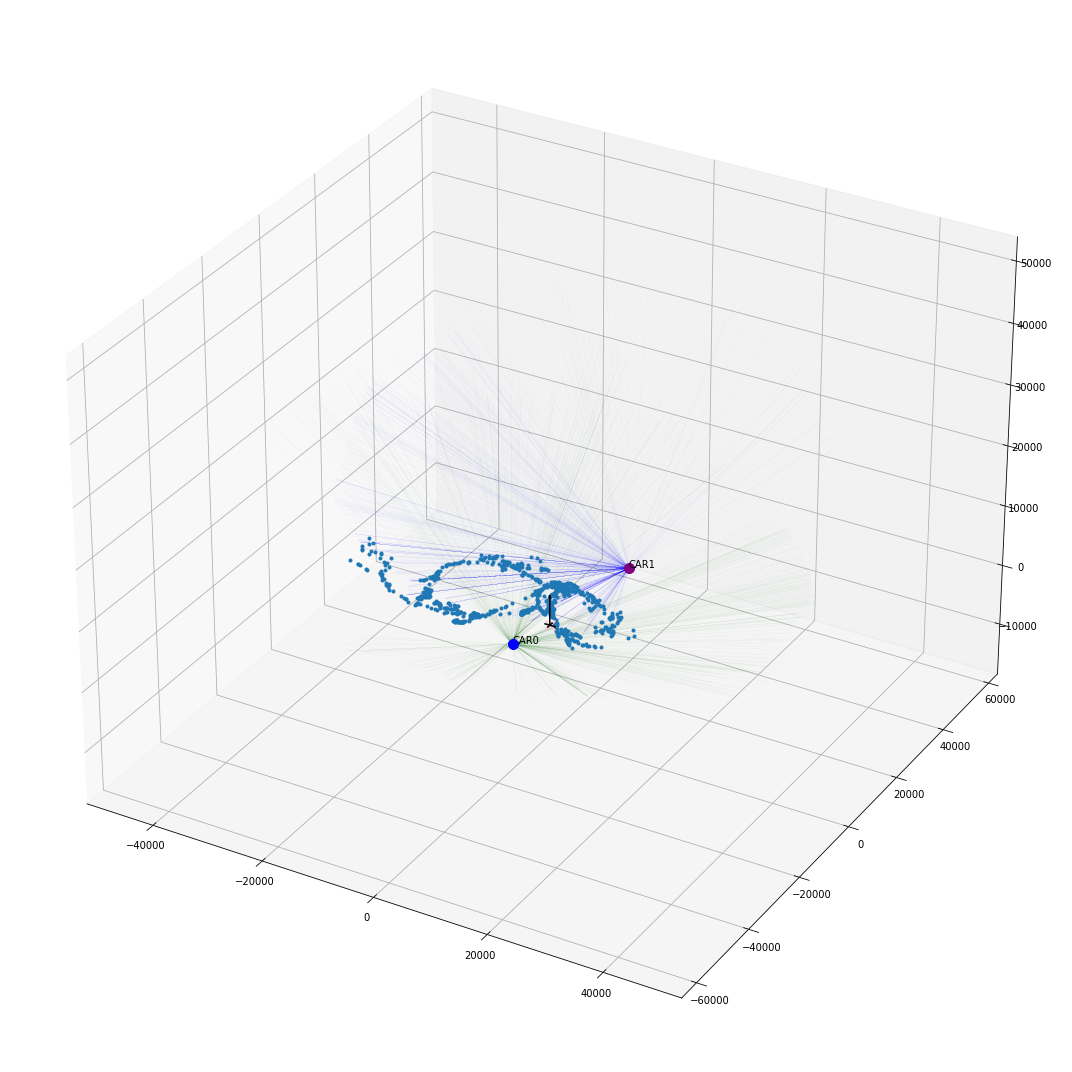

In [79]:
plot = 1

lights = []



car0_enu = pm.geodetic2enu(*cameras[0].coord, *ref_coord) # ENU souradnice auta 
car1_enu = pm.geodetic2enu(*cameras[1].coord, *ref_coord) # ENU souradnice auta
print("auto 0", car0_enu)
print("auto 1", car1_enu)


if plot:
    fig = plt.figure(figsize =(15, 15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(*car0_enu, color="BLUE", marker="o", s = 100)
    ax.text(*car0_enu, "CAR0")
    ax.scatter(*car1_enu, color="PURPLE", marker="o", s = 100)
    ax.text(*car1_enu, "CAR1")
    ax.scatter(0,0,0, color="pink", marker="x", s = 100)

    
for i, blitz in blitzortung.iterrows():
    #print(i, blitz['lon'])
    enu = pm.geodetic2enu(blitz['lon'], blitz['lat'], ref_coord[2], *ref_coord)
    blitzortung.loc[i, 'enu_x'] = enu[0]
    blitzortung.loc[i, 'enu_y'] = enu[1]
    blitzortung.loc[i, 'enu_z'] = enu[2]
    

x = []
y = []
z = []

mark = 0
for pi, point in enumerate(data):
    #print(pi)
    #for i, x in enumerate(point):
    #    c = cameras[i].coord
    #    rotation = (c[0]-lat0, c[1]-lon0, 0) # naklopeni auta oproti referencnimu mistu (brano okolo NED osy)
    #    #print(i, x, chronos_lens(*x), pm.geodetic2ENU(*c, lat0, lon0, alt0), c[0]-lat0, c[1]-lon0)
    
    p0 = chronos_lens(*point[0])
    p1 = chronos_lens(*point[1])
    
    light0 = spherical_to_cartesian(90-p0[0], p0[1]) # Smer k blesku v kartezkych souradnicich
    light1 = spherical_to_cartesian(90-p1[0], p1[1]+185)
    
    car0_dir = list( map(add, car0_enu, light0) ) # Pricti k NED auta kartezsy smer k blesku
    car1_dir = list( map(add, car1_enu, light1) )
    #print(car0_ned, car0_dir, car1_enu, car1_dir)
    #est = estimate_point_pos(car0_enu, car0_dir, car1_enu, car1_dir)
    est,pa,pb,dist = closestDistanceBetweenLines(car0_enu, car0_dir, car1_enu, car1_dir)
    mark += dist
    
    if plot:
        ax.plot(*zip(car0_enu, car0_dir), "g-", linewidth=0.01)
        ax.plot(*zip(car1_enu, car1_dir), "b-", linewidth=0.01)
    #print(est)
    
    x.append(est[0])
    y.append(est[1])
    z.append(est[2])
    if plot:
        #ax.scatter(*est)
        #ax.text(*est, str(pi))
        #ax.plot(*est)
        pass

if plot: 
    ax.plot(x, y, z, '.')
if plot:
    xa, ya, za = np.array([[-1000,0,0],[0,-1000,0],[0,0,0]])
    u, v, w = np.array([[2000,0,0],[0,2000,0],[0,0,5000]])
    ax.quiver(xa,ya,za,u,v,w,arrow_length_ratio=0.1, color="black")
    plt.tight_layout()
    ax.grid(True)

    plt.show()
print("Mark", mark/10000000)

In [80]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    #z=(np.array(z)+(np.array(y)+np.array(y).min())*0.1+10000)/10,
    z=(np.array(z)+12000)/20,
    #z=np.array(z),
    mode='markers',
    marker=dict(
        size=2,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    ),   
)])

fig.update_layout(
    title="Lightning 20220520, ENU coordinates, X,Y,Z in m",
#     xaxis_title="East-West",
#     yaxis_title="North-South",
#     zaxis_title="Altitude",
#     legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     )
)

cx, cy, cz = zip(car0_enu, car1_enu)
ct = ["auto0", "auto1"]
fig.add_trace(go.Scatter3d(x=cx, y=cy, z=cz, text = ct, mode='markers', marker = {"size": 6}))
#fig.add_trace(go.Scatter3d(x=[10], y=[10], z=[10], mode='markers', marker = {"size": 2}))

fig.add_trace(go.Scatter3d(x=blitzortung['enu_x'], y=blitzortung['enu_y'], z=blitzortung['enu_z'], text = blitzortung['time'], mode='markers', marker = {"size": 4}))



xs= np.linspace(-40000, 10000, 100)
ys= np.linspace(-20000, 30000, 100)
zs= 0*np.ones((100,100))
mycolorscale = [[0, '#aa9ce2'],
                 [1, '#aa9ce2']]

surf = go.Surface(x=xs, y=ys, z=zs, colorscale=mycolorscale, showscale=False)
fig.add_trace(surf)


fig.update_layout(scene_aspectmode='data', scene_aspectratio=dict(x=1, y=1, z=0.1))


# fig.update_layout(
#          #title='Animation Test',
#          #width=600,
#          #height=600,
#          scene_camera_eye=dict(x=10000, y=10000, z=2000),
#          updatemenus=[dict(type='buttons',
#                   showactive=False,
#                   y=1,
#                   x=0.8,
#                   xanchor='left',
#                   yanchor='bottom',
#                   pad=dict(t=45, r=10),
#                   buttons=[dict(label='Play',
#                                  method='animate',
#                                  args=[None, dict(frame=dict(duration=5, redraw=True), 
#                                                              transition=dict(duration=0),
#                                                              fromcurrent=True,
#                                                              mode='immediate'
#                                                             )]
#                                             )
#                                       ]
#                               )
#                         ]
# )

import pandas as pd
fig.show()
fig.write_html("blesk_out_scaled.html")

In [78]:
print(cy)

(-9774.91557549698, 26414.337091538324)


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import mpld3

html_str = mpld3.fig_to_html(fig)
Html_file= open("blesk.html","w")
Html_file.write(html_str)
Html_file.close()

AttributeError: 'Figure' object has no attribute 'canvas'

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:110% !important; }</style>"))